# Preprocessing and Modelling
### Notebook 3 of 4

# Preprocessing

In this step we will import our data, and covert our text column into numerical values using either a Count Vectorizer or TF-IDF Vectorizer

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
# Read Data
console_cleaned = pd.read_csv('data/console_reddit.csv')

## Data summary

In [3]:
console_cleaned.head()

,subreddit,title,created_utc,stemmed_title
0,1,how did yall get your ps5s?,1656026890,yall get
1,1,ps5 horizon bundle still in stock on ps direct,1656026393,horizon bundl still stock direct
3,1,vrr support for hdmi 1.4...,1656023983,vrr support hdmi 1 4
4,1,slow download speeds?,1656023471,slow download speed
5,1,help with wireless controller bluetooth,1656022598,help wireless control bluetooth


In [4]:
console_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29184 entries, 0 to 29981
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   subreddit      29184 non-null  int64 
 1   title          29184 non-null  object
 2   created_utc    29184 non-null  int64 
 3   stemmed_title  29184 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.1+ MB


There are no null values

In [5]:
# Check for any title with no values
console_cleaned[console_cleaned['stemmed_title'] == '']

,subreddit,title,created_utc,stemmed_title


In [6]:
# rename target variable

console_cleaned.rename({'subreddit': 'is_ps5'}, inplace=True, axis=1)

**Target Labels**
- PS5: 1
- Xbox: 0

## Train-Test-Split

We kept 20% of the data as a holdout sample which is not exposed to any fitting from the modelling. We generate predictions against this dataset.

In [7]:
X = console_cleaned['stemmed_title']
y = console_cleaned['is_ps5']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=42, 
                                                    stratify=y)

In [9]:
# Proportion of target variables
console_cleaned['is_ps5'].value_counts(normalize=True)

1    0.503803
0    0.496197
Name: is_ps5, dtype: float64

The target variable is very balanced with almost equal number of PS5 and Xbox

# Modelling

Since our target variable is a binary value, this is a classification problem. We will evaluate the classification models to get the best model. As a baseline, we will use a Naive Bayes model after performing a Count vectorizer and compare the other models against this baseline. Firstly, we would need to perform either a Count Vectorizer or TF-IDF.

The proportion of target variables are balanced. Therefore, accuracy would be the selected metric to evaluate our models. In addition, in this context, the consequences of False Negative and False Positive is more or less the same. Our goal is to accurately categorise both PS5 and Xbox titles. 

## Baseline Model

### Count Vectorizer

Perform Gridsearch over a count vectorizer and Multinomial Naive bayes model since our features are integer values

In [10]:
pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [11]:
pipe1.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [12]:
pipe1_params = {
    'cvec__max_features': [1000, 2000],
    'cvec__min_df': [0.001, 0.002, 0.005],
    'cvec__ngram_range': [(1, 1), (2, 2), (1, 2)]
}

In [13]:
gs1 = GridSearchCV(pipe1, 
                  param_grid=pipe1_params,
                  cv=5)

In [14]:
gs1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_features': [1000, 2000],
                         'cvec__min_df': [0.001, 0.002, 0.005],
                         'cvec__ngram_range': [(1, 1), (2, 2), (1, 2)]})

In [15]:
gs1.best_score_

0.6960214784012093

In [16]:
pd.DataFrame(gs1.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.110218,0.017125,0.027479,0.009960,2000,0.001,"(1, 1)","{'cvec__max_features': 2000, 'cvec__min_df': 0...",0.687152,0.691435,0.707646,0.695866,0.698008,0.696021,0.006911,1
11,0.313166,0.036364,0.047266,0.012008,2000,0.001,"(1, 2)","{'cvec__max_features': 2000, 'cvec__min_df': 0...",0.687152,0.690364,0.708503,0.695652,0.694367,0.695208,0.007294,2
0,0.099048,0.004536,0.024015,0.002260,1000,0.001,"(1, 1)","{'cvec__max_features': 1000, 'cvec__min_df': 0...",0.685225,0.689722,0.707646,0.693725,0.693939,0.694051,0.007505,3
2,0.244090,0.005741,0.038153,0.007123,1000,0.001,"(1, 2)","{'cvec__max_features': 1000, 'cvec__min_df': 0...",0.682655,0.683512,0.704648,0.694153,0.686442,0.690282,0.008247,4
3,0.109460,0.008052,0.027940,0.005495,1000,0.002,"(1, 1)","{'cvec__max_features': 1000, 'cvec__min_df': 0...",0.673876,0.671949,0.691797,0.690084,0.676590,0.680859,0.008380,5


In [17]:
gs1.score(X_train, y_train)

0.7149526705786611

In [18]:
gs1.score(X_test, y_test)

0.7008737365084804

In [19]:
y_pred = gs1.predict(X_test)

In [20]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)

2110 786 960 1981


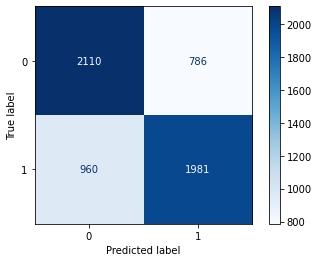

In [21]:
# View confusion matrix
plot_confusion_matrix(gs1, X_test, y_test, cmap='Blues', values_format='d');

Our baseline Naive Bayes model has the accuracy of about 0.70. The scores for the train and test set are fairly similar, indicating that there is no evidence of overfitting.

## Find best models using PyCaret

We will use the Pycaret Library to get the best model

In [24]:
# pip install llvmlite

Note: you may need to restart the kernel to use updated packages.


In [25]:
from pycaret.classification import *

### tf-idf

I will use a TF-IDF vectorizer for my model as it is more robust, looking at both frequency of the words but also the importance of the word relative
to other documents in the corpus. This will reduce the effects of words that are frequent in both Xbox and PS5 subreddit but has no predictive power. 
As seen during the EDA section, there are some top words that appear in both documents. Also, I will proceed with a unigram and bigram bag of words. As
seen from our EDA section, many of the top games and features of each console appear in our top bigram. 

In [26]:
tivec = TfidfVectorizer(min_df=0.001, max_features=2000, ngram_range=(1,2))

In [27]:
X_train_tivec = pd.DataFrame(
    tivec.fit_transform(X_train.values).todense(),
    columns = tivec.get_feature_names()
)

In [28]:
# tranform the test set as well
X_test_tivec = pd.DataFrame(
    tivec.transform(X_test.values).todense(),
    columns = tivec.get_feature_names()
)

## Model Comparison

In [29]:
pyca_df = pd.concat([X_train_tivec, y_train.reset_index(drop=True)], axis=1)

In [30]:
pyca_df.shape

(23347, 1299)

In [31]:
pyca_df.head()

,000,10,100,1080p,11,12,12 month,120,120fp,120hz,13,14,14 day,1440p,15,16,17,18,1st,20,2021,2022,2023,2042,2077,20th,22,23,24,25,28,2k,2k22,2nd,2tb,30,360,360 game,3d,3rd,40,4k,50,60,60 fp,60fp,60hz,99,abl,absolut,ac,access,accord,account,achiev,acquir,acquisit,action,activ,activis,activis blizzard,actual,ad,adapt,add,addit,adventur,advic,age,ago,ahead,ai,allow,almost,alreadi,also,altern,alway,amaz,amazon,and,anim,anniversari,announc,announc trailer,annoy,anoth,answer,anybodi,anybodi els,anymor,anyon,anyon els,anyon know,anyon play,anyth,apex,apex legend,app,appar,appear,april,arcti,ark,around,arriv,art,as,ask,assassin,assassin creed,assist,astro,atmo,audio,august,australia,auto,automat,avail,away,back,background,backward,backward compat,bad,ban,base,batteri,battl,battlefield,battlefield 2042,beat,beauti,becom,behind,believ,best,best buy,best game,best way,beta,bethesda,bethesda game,better,big,biggest,bit,black,black screen,blizzard,bloodborn,bloodhunt,blu,blu ray,blue,bluetooth,boost,boss,bought,box,brand,brand new,break,brick,bring,broke,broken,budget,bug,build,bundl,bungi,button,buy,buy game,c1,cabl,call,call duti,callisto,callisto protocol,came,campaign,can,canada,cancel,cannot,cant,capcom,captur,car,card,care,case,caus,cd,ce,celebr,ceo,certain,challeng,chanc,chang,charact,charg,chat,cheap,check,choos,cinemat,citi,claim,classic,clean,click,clip,close,cloud,cloud game,club,co,co op,cod,code,cold,collect,color,com,combat,come,come game,come soon,comment,commun,compani,compar,comparison,compat,complet,concept,confirm,confus,connect,consid,consol,content,continu,control,control charg,...,softwar,softwar updat,sold,solo,solut,someon,someth,sometim,soni,sonic,sonic frontier,soon,soul,soul hacker,sound,space,speaker,specif,speed,spencer,spider,spider man,spiderman,split,spoiler,sport,spot,spotifi,spring,squar,squar enix,ssd,stand,star,star war,starfield,start,state,state play,stay,steam,stick,stick drift,still,still work,stock,stop,stop work,storag,store,stori,stori mode,strang,stranger,stranger paradis,stream,street,street fighter,struggl,stuck,studio,style,sub,subscrib,subscript,suck,suggest,summer,summer game,sunday,super,support,suppos,sure,surpris,surviv,switch,sx,sync,system,system updat,take,take two,tale,talk,target,team,teas,teaser,tech,tech support,teenag,teenag mutant,tell,test,thank,that,the,the game,the new,theft,theft auto,theme,thi,thing,think,third,though,thought,thread,three,tier,time,tina,tina wonderland,tini,tini tina,tip,titl,tmnt,tmnt shredder,to,to play,today,togeth,tokyo,tomorrow,top,total,trace,track,trade,trailer,trailer game,trailer reveal,transfer,trek,trek yomi,tri,trial,trigger,trilog,trophi,troubl,true,tsushima,turismo,turn,turtl,tv,twitch,twitter,two,type,ubisoft,uk,ukrain,ultim,ultra,unabl,unchart,understand,unit,unlock,unreal,unreal engin,up,upcom,updat,upgrad,upload,us,us part,usa,usb,use,user,valhalla,vampir,vanguard,version,via,video,video game,villag,vision,visual,voic,volum,vr,vr2,vrr,vs,wait,walmart,want,war,war ragnarok,war skywalk,warfar,warranti,warzon,watch,way,way get,weapon,websit,week,weekend,weird,well,went,west,what,white,wifi,will,win,window,wire,wireless,wireless headset,wish,witcher,with,without,wonder,wonderland,wont,work,world,worri,worst,worth,would,wrong,wwe,xbox,xbox one,xsx,year,yesterday,yet,yomi,you,your,youtub,youtub app,zero,is_ps5
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.291728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [32]:
numeric_cols = list(pyca_df.columns)
numeric_cols = numeric_cols[:-1]

### Setup Pycaret for Model Comparison

In [33]:
pyca_model = setup(data = pyca_df, numeric_features=numeric_cols, target = 'is_ps5', session_id=728)

,Description,Value
0,session_id,728
1,Target,is_ps5
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(23347, 1299)"
5,Missing Values,False
6,Numeric Features,1298
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [34]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7021,0.7663,0.6939,0.7101,0.7018,0.4043,0.4046,12.7020
rf,Random Forest Classifier,0.7018,0.7773,0.6899,0.7113,0.7003,0.4038,0.4041,8.2700
lr,Logistic Regression,0.6983,0.7865,0.7082,0.6988,0.7034,0.3964,0.3965,0.8410
svm,SVM - Linear Kernel,0.6969,0.0000,0.7252,0.6927,0.7069,0.3933,0.3959,0.3810
lightgbm,Light Gradient Boosting Machine,0.6969,0.7825,0.6647,0.7153,0.6890,0.3942,0.3953,0.5270
ridge,Ridge Classifier,0.6956,0.0000,0.6953,0.7003,0.6977,0.3911,0.3912,0.2120
lda,Linear Discriminant Analysis,0.6928,0.7719,0.6931,0.6972,0.6951,0.3855,0.3856,6.1500
xgboost,Extreme Gradient Boosting,0.6837,0.7748,0.5836,0.7357,0.6508,0.3687,0.3770,15.3920
nb,Naive Bayes,0.6781,0.7310,0.6252,0.7047,0.6624,0.3568,0.3593,0.1340
dt,Decision Tree Classifier,0.6628,0.6723,0.6590,0.6688,0.6638,0.3256,0.3257,4.7140


Models to evaluate
- Logistic Regression
- Light GBM
- Random Forest

Extra Trees Classifier is too similar to the Random Forest Model, so we will not evaluate it. SVM and LightGBM gives the same score. I will go ahead with LightGBM to explore the effectiveness of a boosting ensemble model.

### Create Model

In [35]:
lr_model = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6875,0.7781,0.7046,0.6855,0.6949,0.3747,0.3748
1,0.7138,0.7948,0.7107,0.7194,0.7150,0.4275,0.4276
2,0.7222,0.7984,0.7382,0.7190,0.7285,0.4441,0.4443
3,0.7124,0.7951,0.7079,0.7183,0.7131,0.4248,0.4248
4,0.6983,0.7964,0.7079,0.6986,0.7032,0.3964,0.3965
5,0.6983,0.7987,0.7212,0.6935,0.7071,0.3963,0.3966
6,0.6720,0.7619,0.6755,0.6755,0.6755,0.3439,0.3439
7,0.6860,0.7703,0.7022,0.6848,0.6934,0.3718,0.3720
8,0.6940,0.7877,0.6937,0.6988,0.6962,0.3880,0.3880


In [36]:
lgbm_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6917,0.7776,0.6755,0.7028,0.6889,0.3837,0.3840
1,0.7107,0.7871,0.6731,0.7325,0.7016,0.4218,0.4233
2,0.7013,0.7861,0.6691,0.7197,0.6935,0.4031,0.4041
3,0.6983,0.7890,0.6582,0.7202,0.6878,0.3970,0.3985
4,0.7013,0.7863,0.6703,0.7191,0.6939,0.4030,0.4040
5,0.7075,0.8024,0.6921,0.7182,0.7049,0.4151,0.4154
6,0.6763,0.7637,0.6392,0.6957,0.6662,0.3530,0.3542
7,0.6940,0.7728,0.6574,0.7145,0.6847,0.3885,0.3897
8,0.6940,0.7841,0.6429,0.7215,0.6799,0.3887,0.3910


In [37]:
rf_model = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6893,0.7691,0.6707,0.7013,0.6856,0.3788,0.3792
1,0.7113,0.7817,0.6852,0.7275,0.7057,0.4229,0.4237
2,0.7130,0.7894,0.7103,0.7181,0.7142,0.4260,0.4260
3,0.7075,0.7847,0.6861,0.7210,0.7031,0.4152,0.4157
4,0.6989,0.7740,0.6885,0.7073,0.6978,0.3979,0.3980
5,0.7179,0.7937,0.7382,0.7131,0.7254,0.4355,0.4358
6,0.6836,0.7637,0.6768,0.6910,0.6838,0.3673,0.3673
7,0.6940,0.7634,0.6864,0.7017,0.6940,0.3881,0.3882
8,0.7111,0.7859,0.6792,0.7305,0.7039,0.4227,0.4237


### Tune Model Hyperparameter

In [38]:
tuned_lr = tune_model(lr_model, choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6881,0.7744,0.6985,0.6885,0.6935,0.3760,0.3760
1,0.7174,0.7897,0.7179,0.7214,0.7197,0.4348,0.4348
2,0.7173,0.7946,0.7370,0.7128,0.7247,0.4343,0.4345
3,0.7173,0.7960,0.7164,0.7216,0.7190,0.4345,0.4345
4,0.6995,0.7928,0.7164,0.6969,0.7065,0.3988,0.3990
5,0.6977,0.7955,0.7127,0.6959,0.7042,0.3951,0.3953
6,0.6805,0.7632,0.6852,0.6836,0.6844,0.3610,0.3610
7,0.6928,0.7686,0.7119,0.6901,0.7008,0.3853,0.3855
8,0.6958,0.7864,0.6949,0.7009,0.6979,0.3917,0.3917


In [39]:
tuned_lgbm = tune_model(lgbm_model, choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6807,0.7617,0.6804,0.6854,0.6829,0.3614,0.3615
1,0.6838,0.7681,0.6441,0.7046,0.6730,0.3681,0.3695
2,0.6965,0.7814,0.6545,0.7190,0.6853,0.3934,0.3950
3,0.6983,0.7851,0.6521,0.7231,0.6858,0.3971,0.3991
4,0.6867,0.7737,0.6679,0.6984,0.6828,0.3735,0.3739
5,0.7056,0.7909,0.6897,0.7166,0.7029,0.4114,0.4117
6,0.6781,0.7595,0.6416,0.6974,0.6683,0.3567,0.3578
7,0.6787,0.7639,0.7167,0.6704,0.6928,0.3568,0.3577
8,0.6873,0.7756,0.6525,0.7064,0.6784,0.3750,0.3761


In [40]:
tuned_rf = tune_model(rf_model, choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6098,0.6862,0.8329,0.5791,0.6832,0.2159,0.2410
1,0.6024,0.6738,0.8208,0.5746,0.6760,0.2012,0.2235
2,0.6212,0.6951,0.8376,0.5876,0.6907,0.2391,0.2650
3,0.6261,0.6924,0.8497,0.5901,0.6965,0.2488,0.2780
4,0.5991,0.6710,0.8182,0.5720,0.6733,0.1948,0.2165
5,0.6273,0.7047,0.8412,0.5922,0.6950,0.2514,0.2780
6,0.6212,0.6870,0.8499,0.5865,0.6940,0.2384,0.2680
7,0.6193,0.6890,0.8438,0.5857,0.6915,0.2348,0.2626
8,0.6218,0.6830,0.8366,0.5886,0.6910,0.2399,0.2655


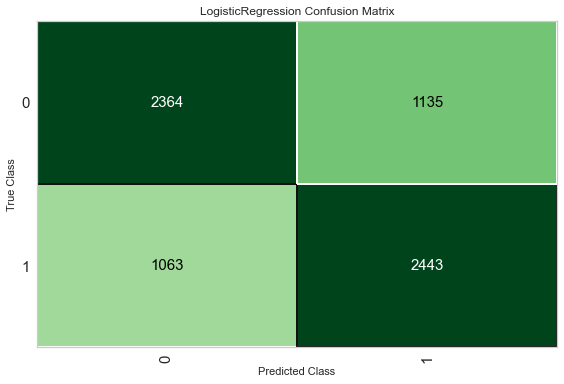

In [41]:
plot_model(tuned_lr, plot = 'confusion_matrix')

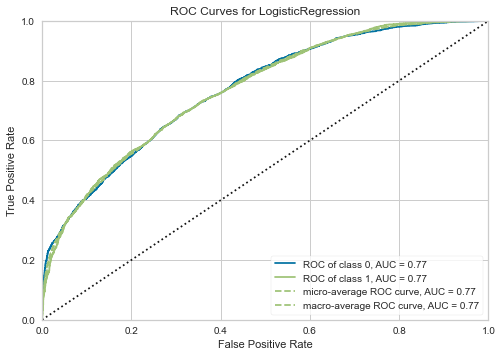

In [42]:
plot_model(tuned_lr, plot = 'auc')

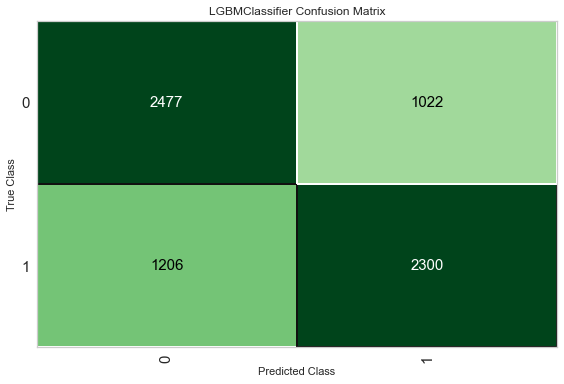

In [43]:
plot_model(tuned_lgbm, plot = 'confusion_matrix')

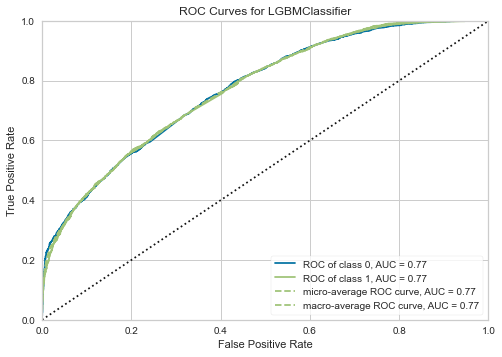

In [44]:
plot_model(tuned_lgbm, plot = 'auc')

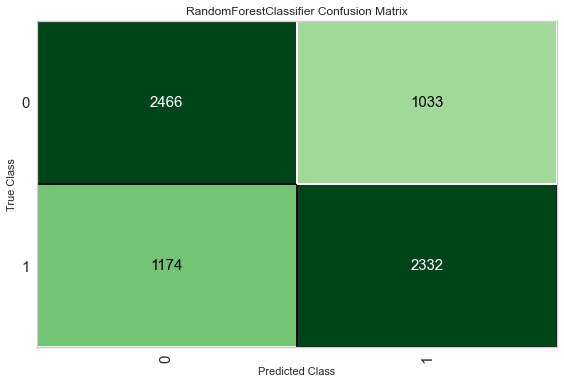

In [45]:
plot_model(tuned_rf, plot = 'confusion_matrix')

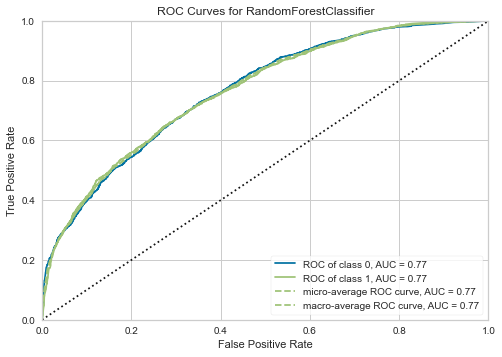

In [46]:
plot_model(tuned_rf, plot = 'auc')

In [47]:
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [48]:
evaluate_model(tuned_lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [49]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Validate against validation set

In [50]:
predict_model(tuned_lr)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6862,0.7691,0.6968,0.6828,0.6897,0.3724,0.3725


,000,10,100,1080p,11,12,12 month,120,120fp,120hz,...,yet,yomi,you,your,youtub,youtub app,zero,is_ps5,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8401
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.5985
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.8280
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.6798
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.6567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8015
7001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.6919
7002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.6397
7003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.7190


In [51]:
predict_model(tuned_lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6819,0.7713,0.6560,0.6924,0.6737,0.3639,0.3644


,000,10,100,1080p,11,12,12 month,120,120fp,120hz,...,yet,yomi,you,your,youtub,youtub app,zero,is_ps5,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9736
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.6459
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9769
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.6862
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.6485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8684
7001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.6441
7002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.7769
7003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9746


In [52]:
predict_model(tuned_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.6849,0.7656,0.6651,0.6930,0.6788,0.3699,0.3702


,000,10,100,1080p,11,12,12 month,120,120fp,120hz,...,yet,yomi,you,your,youtub,youtub app,zero,is_ps5,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9800
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.7200
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1.0000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9400
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.7376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9700
7001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.6758
7002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.7925
7003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8000


**Validation Results**

| Model            | Logistic Regression | Random Forest | LightGBM |
|------------------|---------------------|---------------|----------|
| Validation Score | 0.6862              | 0.6849        | 0.6819   |

Logistic Regression gave the best result against the validation set. However, the scores are very close to one another.

### Finalize Model

This will train our model on the entire train dataset

In [53]:
final_lr = finalize_model(tuned_lr)

In [54]:
final_lgbm = finalize_model(tuned_lgbm)

In [55]:
final_rf = finalize_model(tuned_rf)

In [56]:
predict_model(final_lr)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7205,0.8112,0.7196,0.7213,0.7204,0.4410,0.4410


,000,10,100,1080p,11,12,12 month,120,120fp,120hz,...,yet,yomi,you,your,youtub,youtub app,zero,is_ps5,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8336
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.6023
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.8629
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.6542
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.6635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8320
7001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.6996
7002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.6364
7003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.7736


In [57]:
predict_model(final_lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7472,0.8423,0.7037,0.7712,0.7359,0.4944,0.4963


,000,10,100,1080p,11,12,12 month,120,120fp,120hz,...,yet,yomi,you,your,youtub,youtub app,zero,is_ps5,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9638
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.5909
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9800
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.6680
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.6590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8763
7001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.6089
7002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.6645
7003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9688


In [58]:
predict_model(final_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9493,0.9923,0.9410,0.9571,0.9489,0.8986,0.8988


,000,10,100,1080p,11,12,12 month,120,120fp,120hz,...,yet,yomi,you,your,youtub,youtub app,zero,is_ps5,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9800
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8167
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9800
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9900
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0000
7001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8625
7002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.6600
7003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9200


### Predict against test/holdout set

In [59]:
test_df = pd.concat([X_test_tivec, y_test.reset_index(drop=True)], axis=1)

In [60]:
test_df.shape

(5837, 1299)

In [61]:
test_df.head()

,000,10,100,1080p,11,12,12 month,120,120fp,120hz,...,year,yesterday,yet,yomi,you,your,youtub,youtub app,zero,is_ps5
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


**Logistic Regression**

In [62]:
lr_pred = predict_model(final_lr, data=test_df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7038,0.7875,0.7066,0.7058,0.7062,0.4075,0.4075


In [63]:
lr_pred

,000,10,100,1080p,11,12,12 month,120,120fp,120hz,...,yet,yomi,you,your,youtub,youtub app,zero,is_ps5,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.7295
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.7832
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.5631
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9296
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.6647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9200
5833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.5072
5834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.5650
5835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.5191


**Light GBM**

In [64]:
lgbm_pred = predict_model(final_lgbm, data=test_df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6974,0.7866,0.6545,0.7196,0.6855,0.3953,0.3969


In [65]:
lgbm_pred

,000,10,100,1080p,11,12,12 month,120,120fp,120hz,...,yet,yomi,you,your,youtub,youtub app,zero,is_ps5,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.6976
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8384
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.5089
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9725
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9753
5833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.5089
5834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.6629
5835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.5869


**Random Forest**

In [66]:
rf_pred = predict_model(final_rf, data=test_df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.6896,0.7772,0.6804,0.6965,0.6883,0.3792,0.3793


In [67]:
rf_pred

,000,10,100,1080p,11,12,12 month,120,120fp,120hz,...,yet,yomi,you,your,youtub,youtub app,zero,is_ps5,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.9701
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.6187
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9100
5833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.5297
5834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.7610
5835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.5950


## Model Evaluation

| Model       | Logistic Regression | Random Forest | LightGBM | Naive Bayes |
|-------------|---------------------|---------------|----------|-------------|
| Train Score | 0.7205              | 0.9493        | 0.7472   |    0.7149   |
| Test Score  | 0.7038              | 0.6896        | 0.6974   |    0.7008   |

From our results, Logistic Regression gives the best accuracy of 0.70. This means 70% of the future post are likely to be classified correctly. A Logistic Regression is an effective model for a binary classification problem.  It predicts the target variable by taking in a linear combination of the features as the input. It calculates the probability of the target outcome for each document using the log-odds. The only caveat is that Logistic Regression assumes that the features are independent variables which is likely to be violated in this scenario as the words are likely to be dependent due to the nature of languages.

The other two models show signs of overfitting, especially for Random Forest, as the train score is significantly higher than the test score. The result is also slightly better than our baseline model (0.7008) in terms of accuracy. In addition, a Logistic Regression is computationally inexpensive compared to Random Forest and LightGBM and easy to interpret. Therefore, a Logistic Regression is the best model.